In [1]:
import numpy as np
import pandas as pd
import os

from datasets import load_dataset, DatasetDict

import evaluate

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)

import matplotlib.pyplot as plt

In [2]:
INPUT_DIR = "/input0"
OUTPUT_DIR = "/output/output/bert"
CHECKPOINT = "google-bert/bert-base-multilingual-cased"

In [3]:
# Load data
data = load_dataset("csv", data_files=os.path.join(INPUT_DIR, "train.csv"), trust_remote_code=True, split="train")
data = data.train_test_split(0.2)

data = DatasetDict(
    {
        "train": data["train"],
        "val": data["test"],
        "test": load_dataset("csv", data_files=os.path.join(INPUT_DIR, "test.csv"), trust_remote_code=True, split="train"),
    }
)

data

DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 9696
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 2424
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language'],
        num_rows: 5195
    })
})

In [4]:
df = data["train"].to_pandas()
df.head()

,id,premise,hypothesis,lang_abv,language,label
0,ad107aacdd,这些早期的壁画通常被称为人们的艺术。,当时的批评家将壁画描述为人民艺术。,zh,Chinese,1
1,802c4fa2fb,Sultan Abdul Hamid II (1876 1909) tried to app...,The population was fractured during the rule o...,en,English,0
2,f87aab0ae9,"For example, Bruce Barton's The Man Nobody Kno...","Bruce Barton's, ""The Man Nobody Knows"", a best...",en,English,0
3,05389d7aae,well they're so close to an undefeated undefea...,"They're close to winning the season, so they w...",en,English,0
4,757d48d165,"What a lot of bottles! I exclaimed, as my eye ...",They had drank too many beers.,en,English,1


In [5]:
df[["premise", "hypothesis", "lang_abv", "language"]].describe()

,premise,hypothesis,lang_abv,language
count,9696,9696,9696,9696
unique,7054,9696,15,15
top,i wonder how they kept up with them though it ...,当时的批评家将壁画描述为人民艺术。,en,English
freq,3,1,5516,5516


In [6]:
df[["lang_abv", "language"]].value_counts()

lang_abv  language  
en        English       5516
ar        Arabic         322
fr        French         319
zh        Chinese        318
ur        Urdu           310
el        Greek          309
sw        Swahili        308
vi        Vietnamese     308
ru        Russian        301
hi        Hindi          300
es        Spanish        291
th        Thai           287
de        German         271
bg        Bulgarian      270
tr        Turkish        266
Name: count, dtype: int64

In [7]:
df.isna().sum()

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64

In [8]:
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT, truncation=True)
model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=3)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [9]:
def preprocess_data(batch):
    batch["text"] = [
        x1 + f" {tokenizer.sep_token} " + x2
        for x1, x2 in zip(batch["premise"], batch["hypothesis"])
    ]
    return tokenizer(batch["text"])

data = data.map(preprocess_data, batched=True)
data

Map:   0%|          | 0/9696 [00:00<?, ? examples/s]

Map:   0%|          | 0/2424 [00:00<?, ? examples/s]

Map:   0%|          | 0/5195 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9696
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2424
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5195
    })
})

In [10]:
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    return metric.compute(predictions=preds, references=labels)


train_args = TrainingArguments(
    output_dir=os.path.join(OUTPUT_DIR, "results"),
    logging_dir=os.path.join(OUTPUT_DIR, "logs"),
    report_to=[],
    evaluation_strategy="steps",
    eval_steps=200,
    logging_steps=200,
    save_steps=200,
    per_device_eval_batch_size=16,
    per_device_train_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.005,
    num_train_epochs=5,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=3,
    save_only_model=True,
)

train_args

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'gradient_accumulation_kwargs': None},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_steps=200,
evaluation_strategy=steps,
fp16=True,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_v2': False, 'xla_

In [11]:
trainer = Trainer(
    model=model,
    args=train_args,
    data_collator=data_collator,
    train_dataset=data["train"],
    eval_dataset=data["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(3)],
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy
200,1.028500,0.946657,0.571370
400,0.914800,0.894779,0.598185
600,0.886100,0.848311,0.631188
800,0.721400,0.862519,0.624587
1000,0.700800,0.861043,0.624175
1200,0.713700,0.868733,0.633663
1400,0.493800,0.964047,0.626238
1600,0.494500,0.977991,0.627063
1800,0.468100,0.962311,0.645215
2000,0.322700,1.136691,0.632426


TrainOutput(global_step=2400, training_loss=0.6135502672195434, metrics={'train_runtime': 189.9755, 'train_samples_per_second': 255.191, 'train_steps_per_second': 15.949, 'total_flos': 1974164640096096.0, 'train_loss': 0.6135502672195434, 'epoch': 3.9603960396039604})

In [12]:
log = trainer.state.log_history
log

[{'loss': 1.0285,
  'grad_norm': 12.393720626831055,
  'learning_rate': 1.8693069306930697e-05,
  'epoch': 0.33003300330033003,
  'step': 200},
 {'eval_loss': 0.9466574788093567,
  'eval_accuracy': 0.5713696369636964,
  'eval_runtime': 3.7914,
  'eval_samples_per_second': 639.341,
  'eval_steps_per_second': 40.091,
  'epoch': 0.33003300330033003,
  'step': 200},
 {'loss': 0.9148,
  'grad_norm': 15.201690673828125,
  'learning_rate': 1.7372937293729375e-05,
  'epoch': 0.6600660066006601,
  'step': 400},
 {'eval_loss': 0.8947789072990417,
  'eval_accuracy': 0.5981848184818482,
  'eval_runtime': 3.4879,
  'eval_samples_per_second': 694.977,
  'eval_steps_per_second': 43.579,
  'epoch': 0.6600660066006601,
  'step': 400},
 {'loss': 0.8861,
  'grad_norm': 10.183804512023926,
  'learning_rate': 1.6052805280528056e-05,
  'epoch': 0.9900990099009901,
  'step': 600},
 {'eval_loss': 0.8483108878135681,
  'eval_accuracy': 0.6311881188118812,
  'eval_runtime': 3.5595,
  'eval_samples_per_second': 

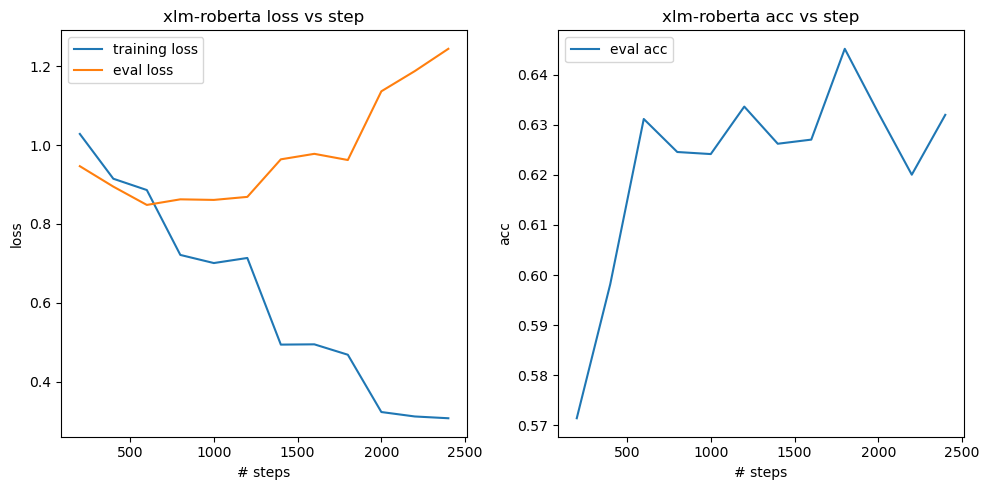

In [13]:
steps = []
train_loss = []
eval_loss = []
eval_acc = []

for i in range(0, len(log) - 1, 2):
    train_log = log[i]
    eval_log = log[i + 1]
    steps.append(train_log["step"])
    train_loss.append(train_log["loss"])
    eval_loss.append(eval_log["eval_loss"])
    eval_acc.append(eval_log["eval_accuracy"])

plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.title("xlm-roberta loss vs step")
plt.xlabel("# steps")
plt.ylabel("loss")
plt.plot(steps, train_loss, label="training loss")
plt.plot(steps, eval_loss, label="eval loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("xlm-roberta acc vs step")
plt.xlabel("# steps")
plt.ylabel("acc")
plt.plot(steps, eval_acc, label="eval acc")
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
preds = trainer.predict(data["test"])
preds

PredictionOutput(predictions=array([[-1.2431641 ,  1.1357422 ,  0.18322754],
       [-2.390625  ,  2.7226562 , -0.28125   ],
       [ 2.6621094 , -1.2548828 , -1.3925781 ],
       ...,
       [-1.3623047 , -0.16259766,  1.3027344 ],
       [ 3.        , -1.7695312 , -1.1757812 ],
       [-2.0957031 , -1.1845703 ,  2.7441406 ]], dtype=float32), label_ids=None, metrics={'test_runtime': 3.7779, 'test_samples_per_second': 1375.117, 'test_steps_per_second': 86.028})

In [15]:
pd.DataFrame(
    {"id": data["test"]["id"], "prediction": np.argmax(preds.predictions, axis=1)}
).to_csv(os.path.join(OUTPUT_DIR, "submission.csv"), header=True, index=False)